# Dataset Cleaning and Reformatting

This notebook will cover some best practices for cleaning time series datasets, including handling missing values, outliers, and more.

## Import Requirements

In [1]:
import pandas as pd
# import pandas_datareader as pdr
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from scipy import stats
import seaborn as sns

# for loading algoseek data
import clickhouse_driver

# for algoseek user credentials
from dotenv import load_dotenv
import os

# to manage paths
import os.path
import sys

# important settings
pd.set_option('max_columns', 100)

## Loading Data from Algoseek Database

In [2]:
# load env file credentials
load_dotenv()

DATABASE_HOST = os.getenv('DATABASE_HOST_1')
DATABASE_USER = os.getenv('DATABASE_USER_1')
DATABASE_PASSWORD = os.getenv('DATABASE_PASSWORD_1')

# connect to database
client = clickhouse_driver.Client(
    DATABASE_HOST,
    user=DATABASE_USER,
    password=DATABASE_PASSWORD,
    secure=False
)

# return available databases
client.execute('show databases')

[('USEquityMarketData',), ('USEquityReferenceData',)]

## Loading Data Locally

In [100]:
df = pd.read_parquet('data/AAPL.parquet')

## Initial Formatting

In [101]:
# Change Date-Time Formatting
datetime = df['BarDateTime'].dt.tz_localize(None)
hour = df['BarDateTime'].dt.hour

In [102]:
# Overwrite BarDateTime column and add Trading Hour column
del df['BarDateTime']
df['Hour'] = hour
df['BarDateTime'] = datetime

In [103]:
# Set index to BarDateTime
df.set_index(['BarDateTime'], inplace=True)

In [104]:
# only include data within market hours
df = df[(df.Hour > 8) & (df.Hour < 16)]

In [8]:
df.index

DatetimeIndex(['2017-12-01 09:00:00', '2017-12-01 09:01:00',
               '2017-12-01 09:02:00', '2017-12-01 09:03:00',
               '2017-12-01 09:04:00', '2017-12-01 09:05:00',
               '2017-12-01 09:06:00', '2017-12-01 09:07:00',
               '2017-12-01 09:08:00', '2017-12-01 09:09:00',
               ...
               '2022-06-21 15:50:00', '2022-06-21 15:51:00',
               '2022-06-21 15:52:00', '2022-06-21 15:53:00',
               '2022-06-21 15:54:00', '2022-06-21 15:55:00',
               '2022-06-21 15:56:00', '2022-06-21 15:57:00',
               '2022-06-21 15:58:00', '2022-06-21 15:59:00'],
              dtype='datetime64[ns]', name='BarDateTime', length=1087348, freq=None)

In [105]:
df = df['2018-01-01 09:00:00':'2022-06-01 15:59:00']

C:\Users\angel\AppData\Local\Temp/ipykernel_17872/3775387635.py:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df['2018-01-01 09:00:00':'2022-06-01 15:59:00']


### Calculate Returns

When conducting time series analysis, we analyze returns rather than actual stock price.

In [106]:
# Minute Bar Returns
import decimal

df['Returns'] = df.apply(lambda x:
     (x['LastTradePrice'] - x['FirstTradePrice'])/x['FirstTradePrice'] if x['FirstTradePrice'] != 0
     else decimal.Decimal(0), axis=1)

In [107]:
# check for null values within Returns column in case of issue with calculation
df['Returns'].isnull().values.sum()

0

## Data Cleaning

In [35]:
# check for NaN values
df.isnull().values.any()

False

### Outlier Detection

We will look at returns to see if there are any apparent price or returns anomalies with the Apple data. We will do this by plotting a time series graph for returns, a boxplot, a histogram for returns, and by checking the z-score. Then we will analyze any specific anomalies we see by slicing that data from the dataset. We will also plot time series graphs of First Trade Price and Last Trade Price from a slice surrounding each anomaly.

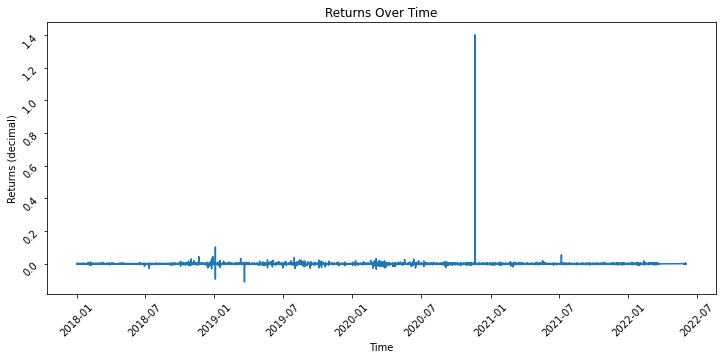

In [108]:
# plot returns time series
plt.figure(figsize=(12,5))
plt.plot(df['Returns'])

plt.title('Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Returns (decimal)')
plt.tick_params(rotation=45)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

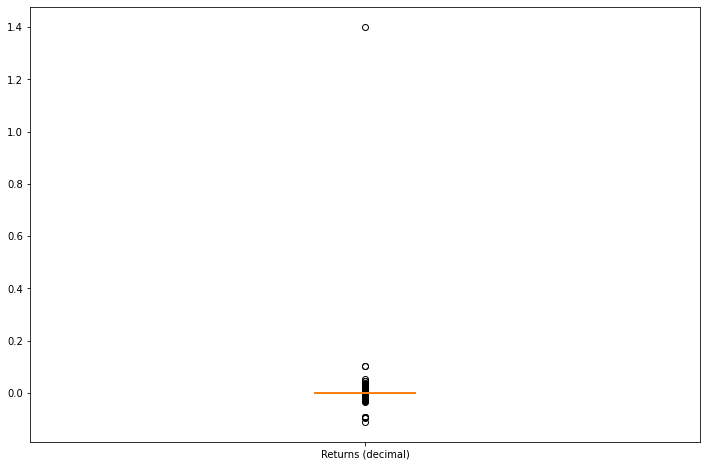

In [109]:
# boxplot
df['Returns'] = df['Returns'].astype(float)

plt.figure(figsize=(12,8))
plt.boxplot(df['Returns'], labels=['Returns (decimal)'], patch_artist=True, medianprops={'linewidth': 2})
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

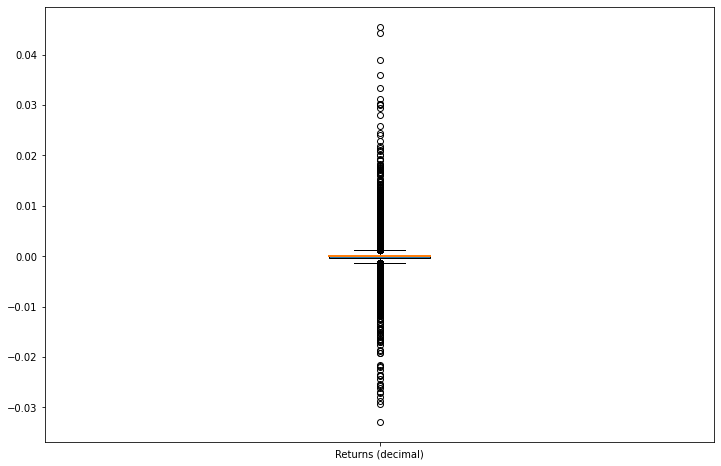

In [110]:
# boxplot without outliers
returns = df[(df['Returns'] > -0.05) & (df['Returns'] < 0.05)]

plt.figure(figsize=(12,8))
plt.boxplot(returns['Returns'], labels=['Returns (decimal)'], patch_artist=True, medianprops={'linewidth': 2})
plt.show

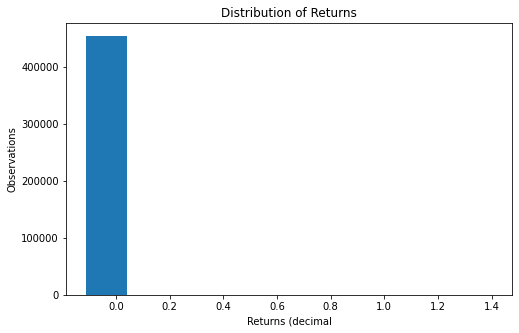

In [86]:
# histogram
plt.figure(figsize=(8,5))

plt.hist(df['Returns'], bins=10)

plt.ylabel('Observations')
plt.xlabel('Returns (decimal')
plt.title('Distribution of Returns')

plt.show()

Given the outliers, this histogram doesn't tell us much. To check that returns are normally distributed, we will create a temporary dataframe without outliers. We will address the outliers in the next few cells.

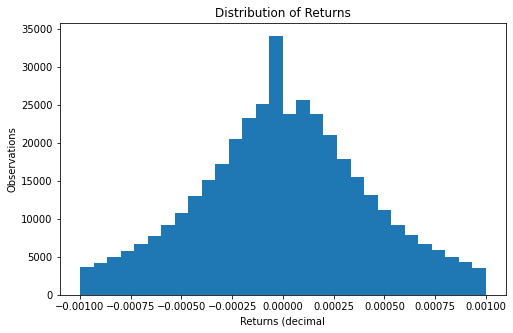

In [124]:
# histogram without outliers
plt.figure(figsize=(8,5))

returns = df[(df['Returns'] > -0.001) & (df['Returns'] < 0.001)]
returns.head()
plt.hist(returns['Returns'], bins=30)

plt.ylabel('Observations')
plt.xlabel('Returns (decimal')
plt.title('Distribution of Returns')

plt.show()

Our histogram show that Returns are, in fact, normally distributed as we should expect (excluding outliers). There is, however, an excess amount of 0% returns due to some minute bars not having any trades on record.

In [75]:
# get z-score
returns = df['Returns']
# outliers above mean
outliers = df[(np.abs(stats.zscore(returns)) > 3)]
# outliers below mean
outliers.append(df[(np.abs(stats.zscore(returns)) < -3)])
outliers

,TradeDate,Ticker,SecId,OpenBarTimeOffset,OpenBidPrice,OpenBidSize,OpenAskPrice,OpenAskSize,FirstTradeTimeOffset,FirstTradePrice,FirstTradeSize,HighBidTimeOffset,HighBidPrice,HighBidSize,HighAskTimeOffset,HighAskPrice,HighAskSize,HighTradeTimeOffset,HighTradePrice,HighTradeSize,LowBidTimeOffset,LowBidPrice,LowBidSize,LowAskTimeOffset,LowAskPrice,LowAskSize,LowTradeTimeOffset,LowTradePrice,LowTradeSize,CloseBarTimeOffset,CloseBidPrice,CloseBidSize,CloseAskPrice,CloseAskSize,LastTradeTimeOffset,LastTradePrice,LastTradeSize,MinSpread,MaxSpread,CancelSize,VolumeWeightPrice,NBBOQuoteCount,TradeAtBid,TradeAtBidMid,TradeAtMid,TradeAtMidAsk,TradeAtAsk,TradeAtCrossOrLocked,Volume,TotalTrades,FinraVolume,FinraVolumeWeightPrice,UptickVolume,DowntickVolume,RepeatUptickVolume,RepeatDowntickVolume,UnknownTickVolume,TradeToMidVolWeight,TradeToMidVolWeightRelative,TimeWeightBid,TimeWeightAsk,Hour,Returns
BarDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-05 15:09:00,2018-02-05,AAPL,0,0,159.86,300,159.91,100,0.030022692,159.9100,45,0E-9,159.86,300,0E-9,159.91,100,0.030022692,159.9100,45,56.677529150,158.60,2700,58.754720968,158.66,100,56.755688605,158.6000,10,59.999999999,158.60,2000,158.66,800,59.959650297,158.6500,1,0.01,0.19,0,159.18796,11164,171747,89735,23965,65550,63760,2692,297433,4404,120016,159.09095,90438,97160,58118,171733,0,-0.99220,-0.16101,159.15656,159.22330,15,-0.007879432180601588393471327622
2018-02-05 15:12:00,2018-02-05,AAPL,0,0,157.30,2500,157.45,300,0.107660416,157.3300,100,37.367691163,159.16,100,36.381925787,159.25,100,36.728921575,159.2500,1,0E-9,157.30,2500,0.483865531,157.40,1000,0.117424588,157.3200,600,59.999999999,158.71,100,158.85,100,59.985151237,158.7500,100,0.01,0.38,0,158.45402,4960,36842,151245,31808,114621,136234,200,294798,4019,176152,158.50744,141062,116924,118999,93965,0,1.21571,0.14820,158.42317,158.53354,15,0.009025614949469268416703743723
2018-02-05 15:14:00,2018-02-05,AAPL,0,0,157.66,200,157.76,600,0.006195047,157.6600,24,49.436474157,158.95,100,45.033592513,159.00,6500,45.041554298,159.0000,100,9.133942627,157.10,300,9.137299469,157.21,200,9.133935981,157.1000,100,59.999999999,158.61,1000,158.85,100,59.928793034,158.8462,15,0.01,0.42,0,158.28365,3296,71930,91038,26976,88884,73891,602,179382,2614,173939,158.30975,122839,128601,58319,43562,0,0.78674,0.07397,158.24430,158.37495,15,0.007523785360903209438031206394
2018-02-06 09:31:00,2018-02-06,AAPL,0,0,155.30,700,155.35,200,0.022287898,155.3000,100,54.323847694,156.97,200,53.068886679,157.00,21100,53.071953056,157.0000,2,8.987247616,155.07,700,8.987149093,155.09,100,57.249119936,154.6800,1,59.999999999,156.90,100,156.98,600,59.969662325,156.9799,50,0.01,0.20,0,155.92807,9780,145593,118558,118705,149308,206152,2102,402261,5515,338157,155.90635,191618,169044,274825,104931,0,0.23141,0.09803,155.79738,155.87853,9,0.01081712813908564069542820348
2018-02-06 09:57:00,2018-02-06,AAPL,0,0,159.62,100,159.69,100,0.071971488,159.6812,62,0E-9,159.62,100,0E-9,159.69,100,0.071971488,159.6812,62,53.445094117,158.05,100,52.845384754,158.10,200,53.175114678,158.0800,44,59.999999999,158.44,200,158.60,800,59.979625952,158.5800,5,0.01,0.22,0,158.82699,9302,139664,126595,30097,110750,46986,1419,284309,3825,171202,158.77343,129230,147678,48275,130328,0,-1.09061,-0.22942,158.71070,158.80228,9,-0.006896240759713729606240434065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24 09:32:00,2022-02-24,AAPL,0,0,152.81,700,152.85,100,0.001660352,152.8500,100,45.768299532,154.16,100,44.799511220,154.17,1300,45.505799444,154.1700,300,0E-9,152.81,700,0E-9,152.85,100,36.393519686,152.2000,1,59.999999999,154.02,200,154.04,600,59.995605697,154.0200,5,0.01,0.06,0,153.68874,29054,423093,172995,198858,132062,531779,8847,865162,13575,602472,153.67536

Our z-score calculation shows we have almost 500 outliers. However, removing outliers for time series data may introduce bias to any models we train, so it may be best to leave most outliers in the dataset. However, we have several extremely abnormal outliers that may taint our future models, which we will further investigate now.

In [163]:
# check for when returns are greater than 5% so we can plot First and Last Trade Price
df.loc[df['Returns'] > 0.05]

,TradeDate,Ticker,SecId,OpenBarTimeOffset,OpenBidPrice,OpenBidSize,OpenAskPrice,OpenAskSize,FirstTradeTimeOffset,FirstTradePrice,FirstTradeSize,HighBidTimeOffset,HighBidPrice,HighBidSize,HighAskTimeOffset,HighAskPrice,HighAskSize,HighTradeTimeOffset,HighTradePrice,HighTradeSize,LowBidTimeOffset,LowBidPrice,LowBidSize,LowAskTimeOffset,LowAskPrice,LowAskSize,LowTradeTimeOffset,LowTradePrice,LowTradeSize,CloseBarTimeOffset,CloseBidPrice,CloseBidSize,CloseAskPrice,CloseAskSize,LastTradeTimeOffset,LastTradePrice,LastTradeSize,MinSpread,MaxSpread,CancelSize,VolumeWeightPrice,NBBOQuoteCount,TradeAtBid,TradeAtBidMid,TradeAtMid,TradeAtMidAsk,TradeAtAsk,TradeAtCrossOrLocked,Volume,TotalTrades,FinraVolume,FinraVolumeWeightPrice,UptickVolume,DowntickVolume,RepeatUptickVolume,RepeatDowntickVolume,UnknownTickVolume,TradeToMidVolWeight,TradeToMidVolWeightRelative,TimeWeightBid,TimeWeightAsk,Hour,Returns
BarDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03 14:03:00,2019-01-03,AAPL,0,0,143.19,300,143.20,1300,0.070104008,143.2000,100,20.146701977,143.26,300,52.209096425,143.28,2400,16.383816546,157.9200,1,1.482655639,143.06,1000,1.490168507,143.07,400,12.283042587,143.0034,15,59.999999999,143.21,500,143.22,600,59.711314575,157.9200,1,0.01,0.06,0,143.20079,1882,26501,23134,10293,46028,18456,413,51736,991,73089,143.20986,49753,31916,18528,24628,0,-0.30491,-0.11510,143.19830,143.21700,14,0.1027932960893854748603351955
2019-01-03 14:05:00,2019-01-03,AAPL,0,0,143.11,1400,143.16,1000,0.142807463,143.1350,6,26.033307257,143.26,100,25.226549854,143.28,1200,0.755823427,157.9200,1,0E-9,143.11,1400,50.782148785,143.12,100,2.127453697,143.1101,5,59.999999999,143.20,400,143.21,100,59.907580671,157.9200,1,0.01,0.05,0,143.20793,1684,17105,14213,8449,16819,35216,700,53822,826,38680,143.21708,17788,32624,18687,23403,0,0.30527,0.19720,143.18430,143.20440,14,0.1032940929891361302267090509
2020-11-20 09:13:00,2020-11-20,AAPL,0,0,118.72,100,118.73,800,0.095896822,118.7200,7,5.627417715,118.74,100,5.627854333,118.76,400,58.934604433,285.0800,10,5.483442617,118.70,100,0E-9,118.73,800,0.095896822,118.7200,7,59.999999999,118.70,500,118.74,300,58.934604433,285.0800,10,0.01,0.04,0,118.73144,74,564,76,22,12,512,0,1045,50,141,130.53035,507,171,480,28,0,-0.02392,-0.02767,118.72273,118.75215,9,1.401280323450134770889487871
2021-07-07 12:24:00,2021-07-07,AAPL,0,0,143.99,3900,144.00,1100,0.224996617,136.5500,28,58.517135114,144.06,200,58.517501678,144.07,3600,59.454980284,144.0700,1,0.409889825,143.97,3400,0.409776500,143.98,100,0.224996617,136.5500,28,59.999999999,144.06,5600,144.07,700,59.928260478,144.0650,1,0.01,0.02,0,144.02839,4996,40078,31267,35477,54242,51114,6425,77037,1259,141566,144.01932,73521,50753,39427,54902,0,0.01682,0.01682,144.01574,144.02574,12,0.05503478579274990845844013182


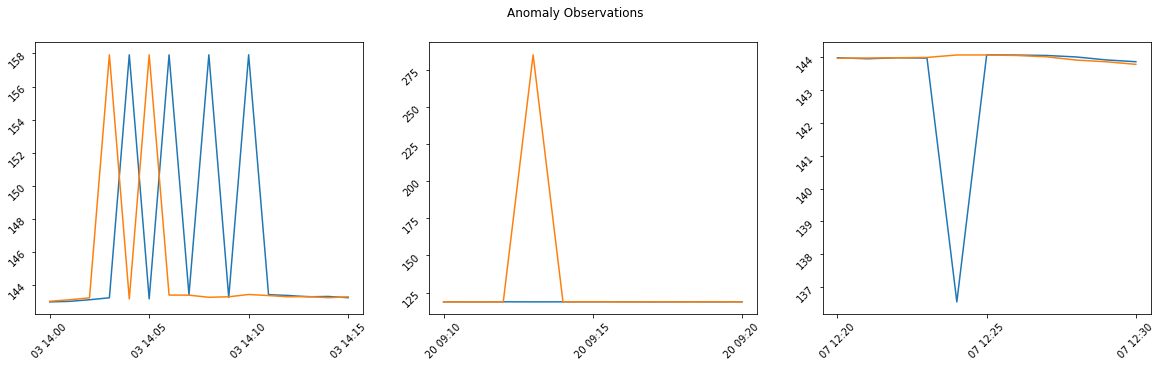

In [162]:
# plot outlier observations
observation_1 = df['2019-01-03 14:00:00':'2019-01-03 14:15:00']
observation_2 = df['2020-11-20 09:10:00':'2020-11-20 9:20:00']
observation_3 = df['2021-07-07 12:20:00':'2021-07-07 12:30:00']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Anomaly Observations')
fig.set_figheight(5)
fig.set_figwidth(20)

ax1.plot(observation_1['FirstTradePrice'])
ax1.plot(observation_1['LastTradePrice'])
ax1.tick_params(rotation=45)

ax2.plot(observation_2['FirstTradePrice'])
ax2.plot(observation_2['LastTradePrice'])
ax2.tick_params(rotation=45)

ax3.plot(observation_3['FirstTradePrice'])
ax3.plot(observation_3['LastTradePrice'])
ax3.tick_params(rotation=45)

In [166]:
# check for when returns are less than -5% so we can plot First and Last Trade Price
df.loc[df['Returns'] < -0.05]

,TradeDate,Ticker,SecId,OpenBarTimeOffset,OpenBidPrice,OpenBidSize,OpenAskPrice,OpenAskSize,FirstTradeTimeOffset,FirstTradePrice,FirstTradeSize,HighBidTimeOffset,HighBidPrice,HighBidSize,HighAskTimeOffset,HighAskPrice,HighAskSize,HighTradeTimeOffset,HighTradePrice,HighTradeSize,LowBidTimeOffset,LowBidPrice,LowBidSize,LowAskTimeOffset,LowAskPrice,LowAskSize,LowTradeTimeOffset,LowTradePrice,LowTradeSize,CloseBarTimeOffset,CloseBidPrice,CloseBidSize,CloseAskPrice,CloseAskSize,LastTradeTimeOffset,LastTradePrice,LastTradeSize,MinSpread,MaxSpread,CancelSize,VolumeWeightPrice,NBBOQuoteCount,TradeAtBid,TradeAtBidMid,TradeAtMid,TradeAtMidAsk,TradeAtAsk,TradeAtCrossOrLocked,Volume,TotalTrades,FinraVolume,FinraVolumeWeightPrice,UptickVolume,DowntickVolume,RepeatUptickVolume,RepeatDowntickVolume,UnknownTickVolume,TradeToMidVolWeight,TradeToMidVolWeightRelative,TimeWeightBid,TimeWeightAsk,Hour,Returns
BarDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-03 14:04:00,2019-01-03,AAPL,0,0,143.21,500,143.22,600,0.063432250,157.9200,1,1.607217858,143.22,200,1.607314183,143.23,300,0.063432250,157.9200,1,42.033046282,143.08,100,42.033137149,143.09,100,42.739367490,143.0801,150,59.999999999,143.11,1400,143.16,1000,59.880658132,143.1300,100,0.01,0.05,0,143.14250,1900,22848,21898,4628,17658,20304,400,44192,812,43544,143.18265,29855,25057,10771,22053,0,-0.14282,-0.12615,143.13051,143.14949,14,-0.09365501519756838905775075988
2019-01-03 14:06:00,2019-01-03,AAPL,0,0,143.20,400,143.21,100,0.034368357,157.9200,1,22.005398135,143.36,200,59.476218932,143.38,3100,0.034368357,157.9200,1,7.908319370,143.19,1000,8.245633264,143.20,100,7.909639206,143.1900,100,59.999999999,143.35,2100,143.38,600,59.908561079,143.3650,400,0.01,0.05,0,143.30990,1386,14510,16359,21455,27687,27075,453,55879,936,51660,143.34099,28244,37668,23988,17639,0,0.20533,0.11414,143.29529,143.31036,14,-0.09216691995947315096251266464
2019-01-03 14:08:00,2019-01-03,AAPL,0,0,143.36,600,143.38,600,0.062044382,157.9200,1,4.955915952,143.42,100,4.955507587,143.43,200,0.062044382,157.9200,1,59.664265122,143.20,1400,24.264214566,143.23,100,59.656251330,143.2100,100,59.999999999,143.21,200,143.23,900,59.699828541,143.2300,8,0.01,0.05,0,143.32004,1896,26192,9945,8149,8343,28499,200,47809,922,33519,143.36422,15102,28456,14326,23444,0,-0.02810,0.00900,143.32288,143.34457,14,-0.09302178318135764944275582573
2019-01-03 14:10:00,2019-01-03,AAPL,0,0,143.25,1500,143.27,1600,0.054249885,157.9200,1,59.494695325,143.39,200,59.980804306,143.41,100,0.054249885,157.9200,1,9.923582894,143.19,600,9.923752824,143.20,500,12.692707641,143.1700,100,59.999999999,143.39,600,143.41,100,59.981088102,143.4000,5,0.01,0.03,0,143.24779,1300,54654,17128,11809,12153,39754,1325,72575,1086,64248,143.24917,26880,53383,29424,27136,0,-0.04108,-0.01375,143.23186,143.24599,14,-0.09194528875379939209726443769
2019-03-21 14:10:00,2019-03-21,AAPL,0,0,195.92,100,195.93,900,0.731109725,195.9256,75,2.222012433,195.93,100,2.221918573,195.94,2000,2.223950641,195.9350,100,36.702064145,195.76,2900,36.702151293,195.77,100,58.485059809,174.2000,20,59.999999999,195.79,600,195.80,2500,58.485059809,174.2000,20,0.01,0.03,0,195.83330,3032,28284,8083,6865,13580,16981,300,37027,575,37066,195.81340,21260,20182,8890,23761,0,-0.20261,-0.18326,195.84146,195.85616,14,-0.1108869897552948670311587664


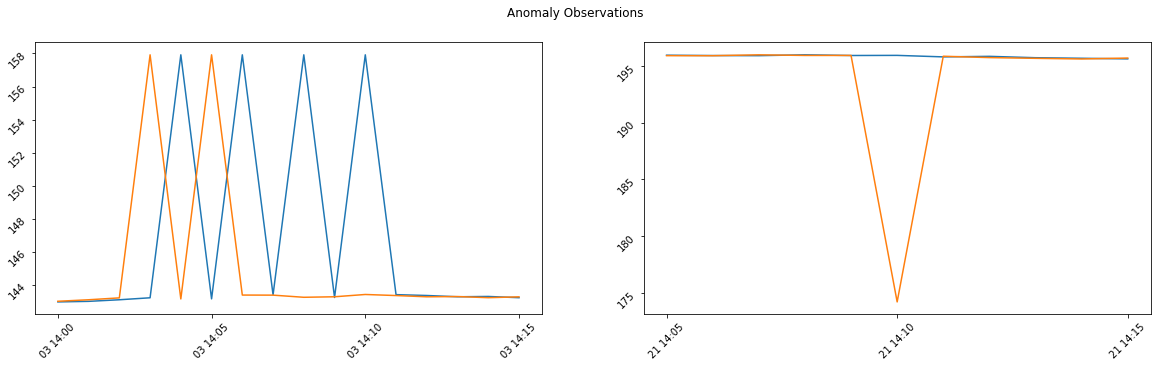

In [177]:
# plot outlier observations
observation_1 = df['2019-01-03 14:00:00':'2019-01-03 14:15:00']
observation_2 = df['2019-03-21 14:05:00':'2019-03-21 14:15:00']

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Anomaly Observations')
fig.set_figheight(5)
fig.set_figwidth(20)

ax1.plot(observation_1['FirstTradePrice'])
ax1.plot(observation_1['LastTradePrice'])
ax1.tick_params(rotation=45)

ax2.plot(observation_2['FirstTradePrice'])
ax2.plot(observation_2['LastTradePrice'])
ax2.tick_params(rotation=45)

## Forward Filling Outliers

In [78]:
# loop through returns
for returns in df['Returns']:

    # outliers cutoff
    if returns > 0.05 or returns < -0.05:
        # get index slice from outlier
        slice = df.loc[df['Returns'] == returns]
        # print(slice.index)
        datetime_index = slice.index
        # convert outliers to NaN so they can be forward filled
        df.loc[datetime_index] = np.nan

        print(datetime_index)
        print(returns)

# forward fill NaN
df = df.ffill()

Series([], Name: Returns, dtype: object)
DatetimeIndex(['2019-03-21 14:10:00'], dtype='datetime64[ns]', name='BarDateTime', freq=None)
-0.1108869897552948670311587664
Series([], Name: Returns, dtype: object)
DatetimeIndex(['2020-11-20 09:13:00'], dtype='datetime64[ns]', name='BarDateTime', freq=None)
1.401280323450134770889487871
Series([], Name: Returns, dtype: object)
DatetimeIndex(['2021-07-07 12:24:00'], dtype='datetime64[ns]', name='BarDateTime', freq=None)
0.05503478579274990845844013182


### Check to see if outliers got replaced

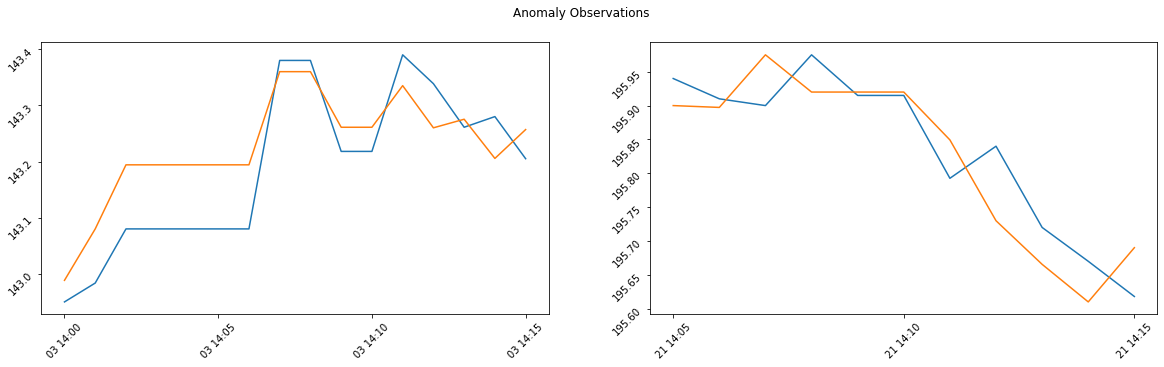

In [79]:
observation_1 = df['2019-01-03 14:00:00':'2019-01-03 14:15:00']
observation_2 = df['2019-03-21 14:05:00':'2019-03-21 14:15:00']

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Anomaly Observations')
fig.set_figheight(5)
fig.set_figwidth(20)

ax1.plot(observation_1['FirstTradePrice'])
ax1.plot(observation_1['LastTradePrice'])
ax1.tick_params(rotation=45)

ax2.plot(observation_2['FirstTradePrice'])
ax2.plot(observation_2['LastTradePrice'])
ax2.tick_params(rotation=45)

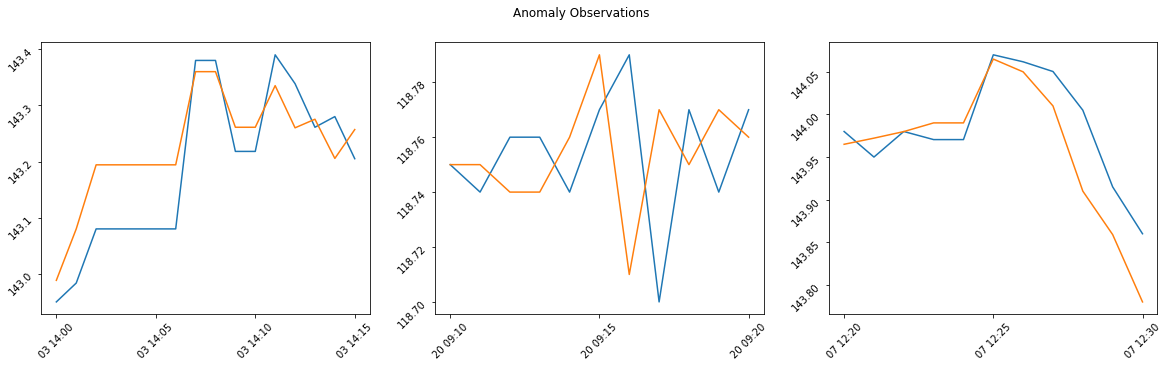

In [80]:
observation_1 = df['2019-01-03 14:00:00':'2019-01-03 14:15:00']
observation_2 = df['2020-11-20 09:10:00':'2020-11-20 9:20:00']
observation_3 = df['2021-07-07 12:20:00':'2021-07-07 12:30:00']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Anomaly Observations')
fig.set_figheight(5)
fig.set_figwidth(20)

ax1.plot(observation_1['FirstTradePrice'])
ax1.plot(observation_1['LastTradePrice'])
ax1.tick_params(rotation=45)

ax2.plot(observation_2['FirstTradePrice'])
ax2.plot(observation_2['LastTradePrice'])
ax2.tick_params(rotation=45)

ax3.plot(observation_3['FirstTradePrice'])
ax3.plot(observation_3['LastTradePrice'])
ax3.tick_params(rotation=45)

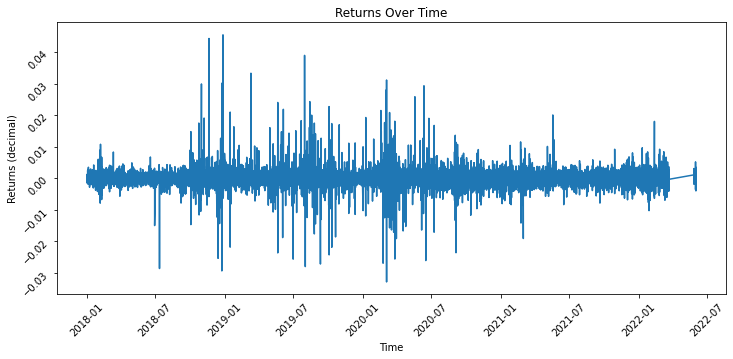

In [82]:
# plot returns time series
plt.figure(figsize=(12,5))
plt.plot(df['Returns'])

plt.title('Returns Over Time')
plt.xlabel('Time')
plt.ylabel('Returns (decimal)')
plt.tick_params(rotation=45)

plt.show()

## Missing Values

This dataset has quite a few missing values as we can see below. Whenever there are no trades for a given minute bar, price is recorded as zero, thus returns will equal zero. The only way to fix this would be either resampling, or by forward/backward filling values. However, this may shift the true distribution of returns, so the only way to determine the best way to handle missing values in this case would be train a model using each technique and compare performances.

In [13]:
df.loc[df['FirstTradePrice'] == 0]

,TradeDate,Ticker,SecId,OpenBarTimeOffset,OpenBidPrice,OpenBidSize,OpenAskPrice,OpenAskSize,FirstTradeTimeOffset,FirstTradePrice,FirstTradeSize,HighBidTimeOffset,HighBidPrice,HighBidSize,HighAskTimeOffset,HighAskPrice,HighAskSize,HighTradeTimeOffset,HighTradePrice,HighTradeSize,LowBidTimeOffset,LowBidPrice,LowBidSize,LowAskTimeOffset,LowAskPrice,LowAskSize,LowTradeTimeOffset,LowTradePrice,LowTradeSize,CloseBarTimeOffset,CloseBidPrice,CloseBidSize,CloseAskPrice,CloseAskSize,LastTradeTimeOffset,LastTradePrice,LastTradeSize,MinSpread,MaxSpread,CancelSize,VolumeWeightPrice,NBBOQuoteCount,TradeAtBid,TradeAtBidMid,TradeAtMid,TradeAtMidAsk,TradeAtAsk,TradeAtCrossOrLocked,Volume,TotalTrades,FinraVolume,FinraVolumeWeightPrice,UptickVolume,DowntickVolume,RepeatUptickVolume,RepeatDowntickVolume,UnknownTickVolume,TradeToMidVolWeight,TradeToMidVolWeightRelative,TimeWeightBid,TimeWeightAsk,Hour,Returns
BarDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-05 09:16:00,2017-12-05,AAPL,0,0,169.89,3100,169.95,500,0E-9,0.0000,0,0E-9,169.89,3100,0E-9,169.95,500,0E-9,0.0000,0,0E-9,169.89,3100,0E-9,169.95,500,0E-9,0.0000,0,59.999999999,169.89,3100,169.95,500,0E-9,0.0000,0,0.06,0.06,0,0.00000,0,0,0,0,0,0,0,0,0,0,0.00000,0,0,0,0,0,0.00000,0.00000,169.89000,169.95000,9,0
2017-12-12 09:00:00,2017-12-12,AAPL,0,0,172.39,100,172.44,600,0E-9,0.0000,0,0E-9,172.39,100,0E-9,172.44,600,0E-9,0.0000,0,0E-9,172.39,100,0E-9,172.44,600,0E-9,0.0000,0,59.999999999,172.39,100,172.44,600,0E-9,0.0000,0,0.05,0.05,0,0.00000,0,0,0,0,0,0,0,0,0,0,0.00000,0,0,0,0,0,0.00000,0.00000,172.39000,172.44000,9,0
2017-12-15 09:14:00,2017-12-15,AAPL,0,0,172.46,100,172.58,200,0E-9,0.0000,0,0E-9,172.46,100,0E-9,172.58,200,0E-9,0.0000,0,0E-9,172.46,100,23.185787805,172.55,200,0E-9,0.0000,0,59.999999999,172.46,100,172.55,200,0E-9,0.0000,0,0.09,0.12,0,0.00000,2,0,0,0,0,0,0,0,0,0,0.00000,0,0,0,0,0,0.00000,0.00000,172.46000,172.56159,9,0
2017-12-15 09:21:00,2017-12-15,AAPL,0,0,172.51,200,172.60,1600,0E-9,0.0000,0,0E-9,172.51,200,0E-9,172.60,1600,0E-9,0.0000,0,0E-9,172.51,200,6.625437336,172.59,200,0E-9,0.0000,0,59.999999999,172.51,200,172.59,200,0E-9,0.0000,0,0.08,0.09,0,0.00000,2,0,0,0,0,0,0,0,0,0,0.00000,0,0,0,0,0,0.00000,0.00000,172.51000,172.59110,9,0
2017-12-20 09:00:00,2017-12-20,AAPL,0,0,174.97,100,175.00,100,0E-9,0.0000,0,0E-9,174.97,100,0E-9,175.00,100,0E-9,0.0000,0,0E-9,174.97,100,0E-9,175.00,100,0E-9,0.0000,0,59.999999999,174.97,100,175.00,100,0E-9,0.0000,0,0.03,0.03,0,0.00000,0,0,0,0,0,0,0,0,0,0,0.00000,0,0,0,0,0,0.00000,0.00000,174.97000,175.00000,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-02 15:55:00,2022-06-02,AAPL,33449,0,150.70,2000,150.71,1700,0E-9,0.0000,0,0E-9,150.70,2000,0E-9,150.71,1700,0E-9,0.0000,0,0E-9,150.70,2000,0E-9,150.71,1700,0E-9,0.0000,0,59.999999999,150.70,2000,150.71,1700,0E-9,0.0000,0,0.01,0.01,0,0.00000,0,0,0,0,0,0,0,0,0,0,0.00000,0,0,0,0,0,0.00000,0.00000,150.70000,150.71000,15,0
2022-06-02 15:56:00,2022-06-02,AAPL,33449,0,150.70,2000,150.71,1700,0E-9,0.0000,0,0E-9,150.70,2000,0E-9,150.71,1700,0E-9,0.0000,0,0E-9,150.70,2000,0E-9,150.71,1700,0E-9,0.0000,0,59.999999999,150.70,2000,150.71,1700,0E-9,0.0000,0,0.01,0.01,0,0.00000,0,0,0,0,0,0,0,0,0,0,0.00000,0,0,0,0,0,0.00000,0.00000,150.70000,150.71000,15,0
2022-06-02 15:57:00,2022-06-02,AAPL,33449,0,150.70,2000,150.71,1700,0E-9,0.0000,0,0E-9,150.70,2000,0E-9,150.71,1700,0E-9,0.0000,0,0E-9,150.70,2000,0E-9,150.71,1700,0E-9,0.0000,0,59.999999999,150.70,2000,150.71,1700,0E-9,0.0000,0,0.01,0.01,0,0.00000,0,0,0,0,0,0,0,0,0,0,0.00000,0,0,0,0,0,0.00000,0.00000,150.70000,150.71000,15,0


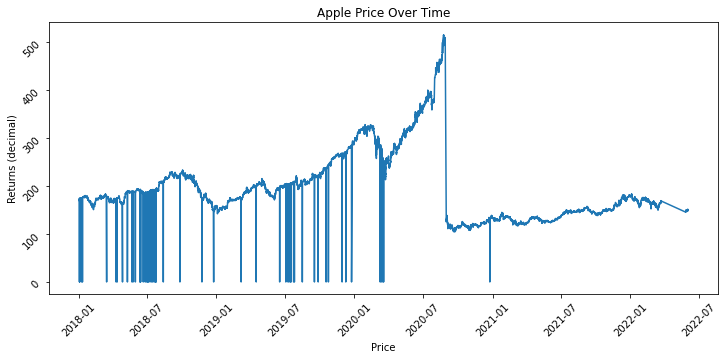

In [97]:
# plot returns time series
plt.figure(figsize=(12,5))
plt.plot(df['LastTradePrice'])

plt.title('Apple Price Over Time')
plt.xlabel('Price')
plt.ylabel('Returns (decimal)')
plt.tick_params(rotation=45)

plt.show()

## Adjusting Price Data to Account for Stock Splits

As we can see above, the stock price has not yet been adjusted for stock splits. We can do so by running the following code

## Save Dataset

In [111]:
df.to_parquet('AAPL_cleaned.parquet')